In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import boto3
import sagemaker
import s3fs
fs = s3fs.S3FileSystem()

In [3]:
BUCKET = 'pose-estimates-for-bodhi' # the name of the bucket containing the pose jsons

In [6]:
for key in s3.list_objects(Bucket = BUCKET)['Contents']:
    print(key['Key'])

Example code - finding bad frames.ipynb
Mouse#20_BalbC_20180423_13-28-05_Front.seq
Mouse#20_BalbC_20180423_13-28-05_Top.seq
Mouse#20_BalbC_20180423_13-28-05_pose_top_v1_5.json
Mouse#20_CastBalbC_20180423_11-37-37_Front.seq
Mouse#20_CastBalbC_20180423_11-37-37_Top.seq
Mouse#20_CastBalbC_20180423_11-37-37_pose_top_v1_5.json
Mouse#22_BalbC_20180423_12-11-55_Front.seq
Mouse#22_BalbC_20180423_12-11-55_Top.seq
Mouse#22_BalbC_20180423_12-11-55_pose_top_v1_5.json
Mouse#23_BalbC_20180423_12-39-09_Front.seq
Mouse#23_BalbC_20180423_12-39-09_Top.seq
Mouse#23_BalbC_20180423_12-39-09_pose_top_v1_5.json
Mouse#24_BalbC_20180423_13-47-49_Front.seq
Mouse#24_BalbC_20180423_13-47-49_Top.seq
Mouse#24_BalbC_20180423_13-47-49_pose_top_v1_5.json
Mouse#25_BalbC_20180423_14-30-32_Front.seq
Mouse#25_BalbC_20180423_14-30-32_Top.seq
Mouse#25_BalbC_20180423_14-30-32_pose_top_v1_5.json
Mouse1100_20180110_20-51-38_Front.seq
Mouse1100_20180110_20-51-38_Top.seq
Mouse1100_20180110_20-51-38_pose_top_v1_5.json
Mouse1100_2

In [5]:
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
s3 = boto3.client('s3')

bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "You S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

In [11]:
# example code- how to load a .json from an s3 bucket into Python:

# get all jsons in the bucket.
json_list = fs.glob('s3://{}/*.json'.format(BUCKET))

# take the first one as an example.
fid = 's3://' + json_list[35]

with fs.open(fid,'rb') as file:
    data = json.load(file)

The dimensions of `data['keypoints']` are (frames) x (mouse number) x (x,y) x (body part).

Body parts are ordered (nose, ear1, ear2, neck, hip1, hip2, tail).

some examples:
- `data['keypoints'][100][0]` gives all keypoints from the first mouse on the 101st (counting from 0) frame.
- `data['keypoints'][100][1][0][2]` gives the x-coordinate of ear2 from the second mouse on the 101st frame.

A few other notes:
- Values are in pixels, with a typical mouse being (I think) ~350 pixels long.
- Sometimes the white mouse is not present at the start of recording: you will be able to tell this because all 7 keypoints will be very small values a few pixels apart.
- In videos that start out with the white mouse being absent, the mouse is lowered into the cage by an experimenter. While the experimenter's hand is present, both mice are often obscured and the pose estimates will jump all over the place- but these frames shouldn't be pulled out as error frames, since human annotators won't know how to label them either!

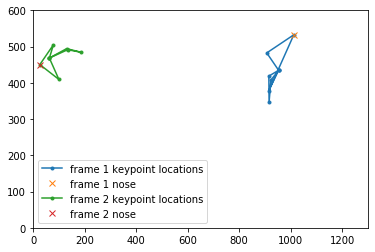

In [13]:
# if we plot the body parts in this order we'll get a figure-8 mouse pose:
point_order = np.array([3, 2, 0, 1, 3, 4, 6, 5, 3])


f1 = 16280

# load the x,y coordinates of all body parts of the first mouse on frame f1 and frame f1+1.
# We convert the data into a numpy array format to make it easier to work with.
frame1 = np.array(data['keypoints'][f1][0])
frame2 = np.array(data['keypoints'][f1+1][0])


# plot where the first mouse is on frame 1, with an x marking the nose.
plt.plot(frame1[0][point_order], frame1[1][point_order],'.-')
plt.plot(frame1[0][0], frame1[1][0],'x')

# plot where the first mouse is on frame 2, with an x marking the nose.
plt.plot(frame2[0][point_order], frame2[1][point_order],'.-')
plt.plot(frame2[0][0], frame2[1][0],'x')

# add a legend, set axis limits, and display the plot.
plt.legend(('frame 1 keypoint locations','frame 1 nose','frame 2 keypoint locations','frame 2 nose'))
plt.xlim(0, 1300)
plt.ylim(0, 600)
plt.show()

In [14]:
# as you can see, the pose estimates on these two frames are pretty close together,
# suggesting that pose estimation is working fine.

# To measure how much the mouse moved between these two frames, we will compute the
# mean Euclidean Distance between each keypoint on frame 1 and each keypoint on frame 2:

dX = frame2[0] - frame1[0]
dY = frame2[1] - frame1[1]
total_change = np.mean(np.sqrt(dX**2 + dY**2)) # **2 squares all the entries of dX.

# displays the total change in keypoint position, in pixels, between these two frames:
print(total_change)

837.4402627661171
